In [2]:
import pandas as pd

In [34]:
df=pd.read_csv("abide2_label.csv")

In [9]:
df1=pd.read_csv('temp.csv')

In [37]:
df.columns

Index(['Unnamed: 0.1', 'Unnamed: 0', 'AGE_AT_SCAN ', 'SEX', 'FIQ',
       'HANDEDNESS_CATEGORY', 'Caption', 'Path', 'Target'],
      dtype='object')

In [35]:
df

,Unnamed: 0.1,Unnamed: 0,AGE_AT_SCAN,SEX,FIQ,HANDEDNESS_CATEGORY,Caption,Path,Target
0,0,0,48.0000,Male,131.0,right handed,A 48-year-old male with an FIQ score of 131 an...,ABIDEII-BNI_1_29006,1
1,1,1,41.0000,Male,110.0,right handed,A 41-year-old male right-handed patient with a...,ABIDEII-BNI_1_29007,1
2,2,2,59.0000,Male,117.0,right handed,"The patient, a 59-year-old right-handed male, ...",ABIDEII-BNI_1_29008,1
3,3,3,57.0000,Male,114.0,right handed,The patient is a 57-year-old right-handed male...,ABIDEII-BNI_1_29009,1
4,4,4,45.0000,Male,109.0,right handed,A 45-year-old male with an FIQ score of 109 an...,ABIDEII-BNI_1_29010,1
...,...,...,...,...,...,...,...,...,...
1108,1108,1108,36.1451,Male,115.0,NaN,The 36-year-old male patient has a FIQ score o...,ABIDEII-USM_1_29523,2
1109,1109,1109,11.7892,Male,99.0,NaN,The patient is an 11-year-old male with a high...,ABIDEII-USM_1_29524,2
1110,1110,1110,23.2909,Male,123.0,right handed,The patient is a 23-year-old right-handed male...,ABIDEII-USM_1_29525,2
1111,1111,1111,32.6242,Male,86.0,NaN,A 32-year-old male with an FIQ score of 86 is ...,ABIDEII-USM_1_29526,2


In [46]:
import os
import pandas as pd
from datasets import Dataset, Features, Image as HFImage, Value, ClassLabel

# 📂 Define dataset root directories
root_dirs = {
    "Autism": r"D:\ABIDE11_3Slices\Autism",
    "NonAutism": r"D:\ABIDE11_3Slices\Non_Autism"
}

# 📝 Load patient metadata (CSV file with 'Path' as Patient ID)
metadata_csv_path = "abide2_label.csv"
df_metadata = pd.read_csv(metadata_csv_path)

# 🛠️ Ensure column names are clean (remove spaces)
df_metadata.columns = df_metadata.columns.str.strip()

# ✅ Extract numeric SUB_ID from CSV for better matching
df_metadata["SUB_ID"] = df_metadata["Path"].str.extract(r'(\d+)$')  # Extract last numeric part
df_metadata["SUB_ID"] = df_metadata["SUB_ID"].astype(str)  # Convert to string for matching

# 📌 Function to load images (axial, coronal, sagittal) from a patient's folder
def load_images(patient_folder):
    images = {"axial": None, "coronal": None, "sagittal": None}
    
    for file in os.listdir(patient_folder):
        file_lower = file.lower()
        if "axial" in file_lower:
            images["axial"] = os.path.join(patient_folder, file)
        elif "coronal" in file_lower:
            images["coronal"] = os.path.join(patient_folder, file)
        elif "sagittal" in file_lower:
            images["sagittal"] = os.path.join(patient_folder, file)
    
    # ✅ Skip patient if any image is missing
    if None in images.values():
        print(f"⚠️ Warning: Missing images in {patient_folder} (Skipping this patient)")
        return None, None, None
    
    return images["axial"], images["coronal"], images["sagittal"]

# 🔍 Process all patient folders
data = []
for label, root_folder in root_dirs.items():
    for patient_id in os.listdir(root_folder):
        patient_folder = os.path.join(root_folder, patient_id)

        if os.path.isdir(patient_folder):  # Ensure it's a directory
            try:
                # ✅ Remove extra "ABIDEII-" prefix (fix mismatch)
                patient_id_cleaned = patient_id.replace("ABIDEII-", "", 1)  # Remove only the first occurrence

                # ✅ Extract numeric ID for better matching
                patient_sub_id = patient_id_cleaned.split("_")[-1]  # Extract last part (e.g., '29006')

                # 📌 Match metadata using cleaned numeric ID
                patient_info = df_metadata[df_metadata["SUB_ID"] == patient_sub_id]

                if patient_info.empty:
                    print(f"⚠️ Warning: No metadata found for {patient_id} (Skipping this patient)")
                    continue  # Skip to next patient

                axial, coronal, sagittal = load_images(patient_folder)
                
                if axial and coronal and sagittal:
                    data.append({
                        "Patient_ID": patient_id_cleaned,
                        "Axial": axial,
                        "Coronal": coronal,
                        "Sagittal": sagittal,
                        "Age": patient_info["AGE_AT_SCAN"].values[0],
                        "Sex": patient_info["SEX"].values[0],
                        "FIQ": patient_info["FIQ"].values[0],
                        "HANDEDNESS_CATEGORY": patient_info["HANDEDNESS_CATEGORY"].values[0],
                        "Label": label,  # Autism / NonAutism
                        "Caption": patient_info["Caption"].values[0]
                    })
            except Exception as e:
                print(f"❌ Error processing {patient_id}: {e} (Skipping)")

# 📝 Convert to DataFrame
df = pd.DataFrame(data)

# 💾 Save updated DataFrame for reference
df.to_csv("updated_dataset1.csv", index=False)
print("✅ CSV file saved as 'updated_dataset1.csv'")

# 🎨 Define Hugging Face dataset features
features = Features({
    "axial_image": HFImage(),
    "coronal_image": HFImage(),
    "sagittal_image": HFImage(),
    "age": Value("int32"),
    "sex": Value("string"),
    "fiq": Value("float32"),
    "HANDEDNESS_CATEGORY": Value("string"),
    "label": ClassLabel(names=["Autism", "NonAutism"]),
    "caption": Value("string"),
    "patient_id": Value("string")
})

# 🔄 Convert DataFrame to Hugging Face Dataset
hf_dataset = Dataset.from_dict({
    "axial_image": df["Axial"].tolist(),
    "coronal_image": df["Coronal"].tolist(),
    "sagittal_image": df["Sagittal"].tolist(),
    "age": df["Age"].tolist(),
    "sex": df["Sex"].tolist(),
    "fiq": df["FIQ"].tolist(),
    "HANDEDNESS_CATEGORY": df["HANDEDNESS_CATEGORY"].tolist(),
    "label": [0 if label == "Autism" else 1 for label in df["Label"]],
    "caption": df["Caption"].tolist(),
    "patient_id": df["Patient_ID"].tolist()
}, features=features)

# 🚀 Push dataset to Hugging Face (optional)
repo_name = "ASD_3D_Images2"  # Change to your dataset name
hf_user = "Bhagya11"  # Change to your Hugging Face username
hf_dataset.push_to_hub(repo_id=f"{hf_user}/{repo_name}")
print(f"🎉 Dataset uploaded to: https://huggingface.co/datasets/{hf_user}/{repo_name}")


⚠️ Warning: Missing images in D:\ABIDE11_3Slices\Non_Autism\ABIDEII-ABIDEII-OILH_2_28728 (Skipping this patient)
✅ CSV file saved as 'updated_dataset1.csv'


Uploading the dataset shards:   0%|          | 0/1 [00:00<?, ?it/s]

Map:   0%|          | 0/845 [00:00<?, ? examples/s]

Creating parquet from Arrow format:   0%|          | 0/9 [00:00<?, ?ba/s]

🎉 Dataset uploaded to: https://huggingface.co/datasets/Bhagya11/ASD_3D_Images2


In [45]:
df

,Patient_ID,Axial,Coronal,Sagittal,Age,Sex,FIQ,HANDEDNESS_CATEGORY,Label,Caption
0,ABIDEII-BNI_1_29006,D:\ABIDE11_3Slices\Autism\ABIDEII-ABIDEII-BNI_...,D:\ABIDE11_3Slices\Autism\ABIDEII-ABIDEII-BNI_...,D:\ABIDE11_3Slices\Autism\ABIDEII-ABIDEII-BNI_...,48.0000,Male,131.0,right handed,Autism,A 48-year-old male with an FIQ score of 131 an...
1,ABIDEII-BNI_1_29007,D:\ABIDE11_3Slices\Autism\ABIDEII-ABIDEII-BNI_...,D:\ABIDE11_3Slices\Autism\ABIDEII-ABIDEII-BNI_...,D:\ABIDE11_3Slices\Autism\ABIDEII-ABIDEII-BNI_...,41.0000,Male,110.0,right handed,Autism,A 41-year-old male right-handed patient with a...
2,ABIDEII-BNI_1_29008,D:\ABIDE11_3Slices\Autism\ABIDEII-ABIDEII-BNI_...,D:\ABIDE11_3Slices\Autism\ABIDEII-ABIDEII-BNI_...,D:\ABIDE11_3Slices\Autism\ABIDEII-ABIDEII-BNI_...,59.0000,Male,117.0,right handed,Autism,"The patient, a 59-year-old right-handed male, ..."
3,ABIDEII-BNI_1_29009,D:\ABIDE11_3Slices\Autism\ABIDEII-ABIDEII-BNI_...,D:\ABIDE11_3Slices\Autism\ABIDEII-ABIDEII-BNI_...,D:\ABIDE11_3Slices\Autism\ABIDEII-ABIDEII-BNI_...,57.0000,Male,114.0,right handed,Autism,The patient is a 57-year-old right-handed male...
4,ABIDEII-BNI_1_29010,D:\ABIDE11_3Slices\Autism\ABIDEII-ABIDEII-BNI_...,D:\ABIDE11_3Slices\Autism\ABIDEII-ABIDEII-BNI_...,D:\ABIDE11_3Slices\Autism\ABIDEII-ABIDEII-BNI_...,45.0000,Male,109.0,right handed,Autism,A 45-year-old male with an FIQ score of 109 an...
...,...,...,...,...,...,...,...,...,...,...
840,ABIDEII-USM_1_29523,D:\ABIDE11_3Slices\Non_Autism\ABIDEII-ABIDEII-...,D:\ABIDE11_3Slices\Non_Autism\ABIDEII-ABIDEII-...,D:\ABIDE11_3Slices\Non_Autism\ABIDEII-ABIDEII-...,36.1451,Male,115.0,NaN,NonAutism,The 36-year-old male patient has a FIQ score o...
841,ABIDEII-USM_1_29524,D:\ABIDE11_3Slices\Non_Autism\ABIDEII-ABIDEII-...,D:\ABIDE11_3Slices\Non_Autism\ABIDEII-ABIDEII-...,D:\ABIDE11_3Slices\Non_Autism\ABIDEII-ABIDEII-...,11.7892,Male,99.0,NaN,NonAutism,The patient is an 11-year-old male with a high...
842,ABIDEII-USM_1_29525,D:\ABIDE11_3Slices\Non_Autism\ABIDEII-ABIDEII-...,D:\ABIDE11_3Slices\Non_Autism\ABIDEII-ABIDEII-...,D:\ABIDE11_3Slices\Non_Autism\ABIDEII-ABIDEII-...,23.2909,Male,123.0,right handed,NonAutism,The patient is a 23-year-old right-handed male...
843,ABIDEII-USM_1_29526,D:\ABIDE11_3Slices\Non_Autism\ABIDEII-ABIDEII-...,D:\ABIDE11_3Slices\Non_Autism\ABIDEII-ABIDEII-...,D:\ABIDE11_3Slices\Non_Autism\ABIDEII-ABIDEII-...,32.6242,Male,86.0,NaN,NonAutism,A 32-year-old male with an FIQ score of 86 is ...


In [30]:
print("First few Patient IDs from CSV:", df_metadata["Path"].head())
print("First few Patient IDs from folder:", os.listdir(root_dirs["Autism"])[:5])


First few Patient IDs from CSV: 0    ABIDEII-BNI_1_29006
1    ABIDEII-BNI_1_29007
2    ABIDEII-BNI_1_29008
3    ABIDEII-BNI_1_29009
4    ABIDEII-BNI_1_29010
Name: Path, dtype: object
First few Patient IDs from folder: ['ABIDEII-ABIDEII-BNI_1_29006', 'ABIDEII-ABIDEII-BNI_1_29007', 'ABIDEII-ABIDEII-BNI_1_29008', 'ABIDEII-ABIDEII-BNI_1_29009', 'ABIDEII-ABIDEII-BNI_1_29010']


In [6]:
df

,Patient_ID,Axial,Coronal,Sagittal,Age,Sex,FIQ,Eye_Status,Label,Caption
0,CALTECH_51456,D:/Datasets/ABIDE_3ASC/Autism\CALTECH_51456\ax...,D:/Datasets/ABIDE_3ASC/Autism\CALTECH_51456\co...,D:/Datasets/ABIDE_3ASC/Autism\CALTECH_51456\sa...,55.40,Male,114.0,closed,Autism,The 55-year-old male patient with an FIQ score...
1,CALTECH_51457,D:/Datasets/ABIDE_3ASC/Autism\CALTECH_51457\ax...,D:/Datasets/ABIDE_3ASC/Autism\CALTECH_51457\co...,D:/Datasets/ABIDE_3ASC/Autism\CALTECH_51457\sa...,22.90,Male,112.0,closed,Autism,The patient is a 23-year-old male with a FIQ s...
2,CALTECH_51458,D:/Datasets/ABIDE_3ASC/Autism\CALTECH_51458\ax...,D:/Datasets/ABIDE_3ASC/Autism\CALTECH_51458\co...,D:/Datasets/ABIDE_3ASC/Autism\CALTECH_51458\sa...,39.20,Male,122.0,closed,Autism,The patient is a male aged 39.2 years with a F...
3,CALTECH_51459,D:/Datasets/ABIDE_3ASC/Autism\CALTECH_51459\ax...,D:/Datasets/ABIDE_3ASC/Autism\CALTECH_51459\co...,D:/Datasets/ABIDE_3ASC/Autism\CALTECH_51459\sa...,22.80,Male,105.0,closed,Autism,"The patient, age 22.8 years old and male, has ..."
4,CALTECH_51460,D:/Datasets/ABIDE_3ASC/Autism\CALTECH_51460\ax...,D:/Datasets/ABIDE_3ASC/Autism\CALTECH_51460\co...,D:/Datasets/ABIDE_3ASC/Autism\CALTECH_51460\sa...,34.60,Female,112.0,closed,Autism,The 34-year-old female patient has an FIQ scor...
...,...,...,...,...,...,...,...,...,...,...
1095,YALE_50574,D:/Datasets/ABIDE_3ASC/NonAutism\YALE_50574\ax...,D:/Datasets/ABIDE_3ASC/NonAutism\YALE_50574\co...,D:/Datasets/ABIDE_3ASC/NonAutism\YALE_50574\sa...,10.92,Male,105.0,open,NonAutism,The 10-year-old male patient's FIQ score of 10...
1096,YALE_50575,D:/Datasets/ABIDE_3ASC/NonAutism\YALE_50575\ax...,D:/Datasets/ABIDE_3ASC/NonAutism\YALE_50575\co...,D:/Datasets/ABIDE_3ASC/NonAutism\YALE_50575\sa...,14.00,Male,103.0,open,NonAutism,A 14-year-old male patient with a FIQ score of...
1097,YALE_50576,D:/Datasets/ABIDE_3ASC/NonAutism\YALE_50576\ax...,D:/Datasets/ABIDE_3ASC/NonAutism\YALE_50576\co...,D:/Datasets/ABIDE_3ASC/NonAutism\YALE_50576\sa...,8.42,Female,91.0,open,NonAutism,The female patient aged 8.42 years has an FIQ ...
1098,YALE_50577,D:/Datasets/ABIDE_3ASC/NonAutism\YALE_50577\ax...,D:/Datasets/ABIDE_3ASC/NonAutism\YALE_50577\co...,D:/Datasets/ABIDE_3ASC/NonAutism\YALE_50577\sa...,15.25,Male,120.0,open,NonAutism,A 15-year-old male patient with an FRIQ score ...


In [40]:
sample_image_path = df["Coronal"].iloc[0]  
# or  
sample_image_path = df["Sagittal"].iloc[0]


In [41]:
sample_image_path

'D:/Datasets/ABIDE_3ASC/Autism\\CALTECH_51456\\sagittal_88.png'

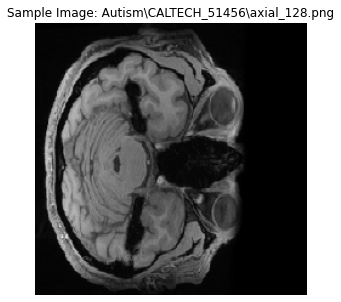

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image

# Load the dataset CSV file
df = pd.read_csv("updated_dataset.csv")

# Pick the first axial image path
sample_image_path = df["Axial"].iloc[0]  # Change to 'Coronal_Path' or 'Sagittal_Path' if needed

# Open and display the image
image = Image.open(sample_image_path)

# Show the image
plt.figure(figsize=(5, 5))
plt.imshow(image, cmap="gray")  # Display in grayscale
plt.axis("off")  # Hide axis
plt.title(f"Sample Image: {sample_image_path.split('/')[-1]}")
plt.show()
